In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
pi = math.pi

In [2]:
#Setup initial forward simulation
S_init = np.array([0, 0, pi/2])
U = np.array([1, -1/2])
P_init = np.array([np.concatenate((S_init, U), axis=None)])

#Forward iteration for P0 (semi-circle initial guess)
T_STEPS = 61
dt = 6/(T_STEPS-1)
t_array = np.zeros(T_STEPS)
for i in range(T_STEPS):
    t_array[i] = i*dt

P0 = np.zeros((T_STEPS, 5))
P0[0] = P_init
for i in range(T_STEPS-1):
    Sdot = np.array([U[0]*math.cos(P0[i][2]), U[0]*math.sin(P0[i][2]), U[1]])*dt
    S_new = P0[i][0:3] + Sdot
    P_new = np.array([np.concatenate((S_new, U), axis=None)])
    P0[i+1] = P_new
#S0 = P0[:,0:3]
#S0 = S0.flatten()

#Initial reference trajectory (S_bar, unattainable)
S_bar = np.zeros((T_STEPS, 3))
for i in range(T_STEPS):
    S_bar[i] = np.array([4*(i*dt)/(2*pi), 0, pi/2])

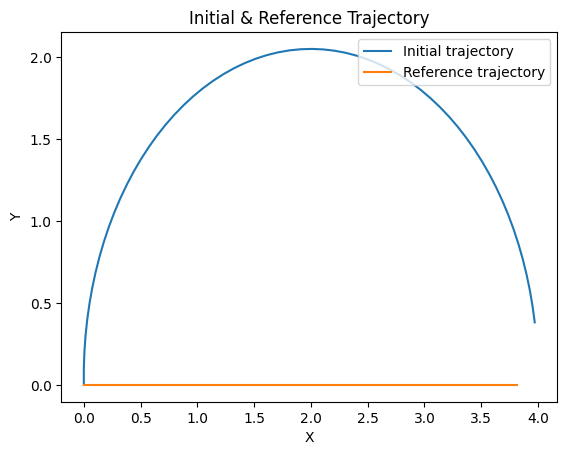

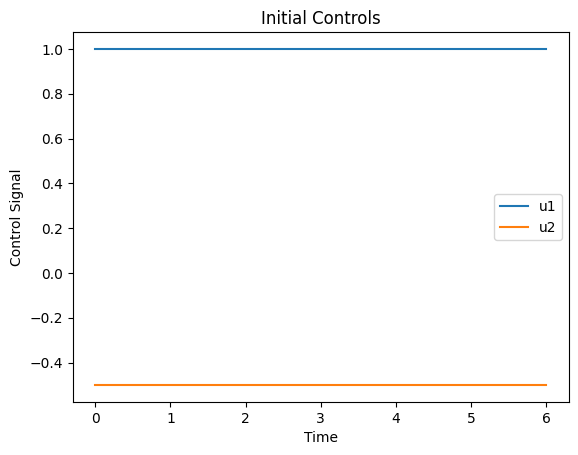

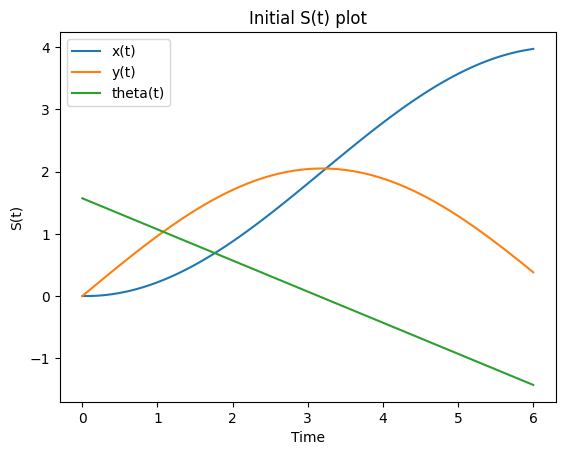

In [3]:
#Initial & Reference Trajectory Plot
plt.figure("Figure 1")
plt.plot(P0[:,0], P0[:,1], label = 'Initial trajectory')
plt.plot(S_bar[:,0], S_bar[:,1], label = 'Reference trajectory')
plt.title("Initial & Reference Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc = 1)

#Initial Controls Plot
plt.figure("Figure 3")
plt.plot(t_array, P0[:,3], label = "u1")
plt.plot(t_array, P0[:,4], label = "u2")
plt.title("Initial Controls")
plt.xlabel("Time")
plt.ylabel("Control Signal")
plt.legend()

#Initial x(t) y(t) theta(t) plot
plt.figure("Figure 4")
plt.plot(t_array, P0[:,0], label = 'x(t)')
plt.plot(t_array, P0[:,1], label = 'y(t)')
plt.plot(t_array, P0[:,2], label = 'theta(t)')
plt.title("Initial S(t) plot")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.legend()

In [13]:
# generating initial guess P(x0) = {x0[0], x0[1], ... , x0[M]}
M=500

x0 = 0
y0 = 0
theta0 = pi/2
x0 = x0 + np.random.normal(0, 0.02**0.5, M)
y0 = y0 + np.random.normal(0, 0.02**0.5, M)
theta0 = theta0 + np.random.normal(0, 0.02**0.5, M)

# x0 = np.random.uniform(-1, 5, M)
# y0 = np.random.uniform(-1, 3, M)
# theta0 = np.random.uniform(-pi/2, pi/2, M)

orig_state = np.vstack((x0, y0, theta0))

std = 0.02**0.5
init_traj = P0[:,0:3]

In [14]:
# defining particle filter functions
def calc_state_weights(state, traj):
    particles = np.zeros([3,M])
    weights = np.zeros(M)
    for m in range(M):
        xdot = np.cos(state[2][m])*U[0]
        ydot = np.sin(state[2][m])*U[0]
        thetadot = U[1]

        new_x = state[0][m]+xdot*dt
        new_y = state[1][m]+ydot*dt
        new_theta = state[2][m]+thetadot*dt

        particles[:,m] = np.array([new_x, new_y, new_theta]) + np.random.normal(0, std, 3)

        znoise = traj + np.random.normal(0, std, 3)
        weight_x = norm.pdf(znoise[0], loc = new_x, scale = std)
        weight_y = norm.pdf(znoise[1], loc = new_y, scale = std)
        weight_theta = norm.pdf(znoise[2], loc = new_theta, scale = std)
        weights[m] = weight_x * weight_y * weight_theta
    
    weights = weights/weights.sum()      
    return particles, weights

def measurement_sampling(particles, weights):
    new_state = np.zeros([3, M])
    sampled = np.random.choice(np.arange(M), M, p = weights)
    for m in range(M):
        new_state[:,m] = particles[:,sampled[m]]
    return new_state


In [15]:
# particle filter
particleFilter = list()
Xbar, weights = calc_state_weights(orig_state, init_traj[0])
X = measurement_sampling(Xbar, weights)
particleFilter.append(X)
av_state = np.zeros([3,T_STEPS])
av_state[:,0] = X.sum(axis=1)/M
for i in range(T_STEPS-1):
    Xbar, weights = calc_state_weights(particleFilter[i], init_traj[i+1])
    X = measurement_sampling(Xbar, weights)
    av_state[:,i+1] = X.sum(axis=1)/M
    particleFilter.append(X)
    



Text(0, 0.5, 'Y')

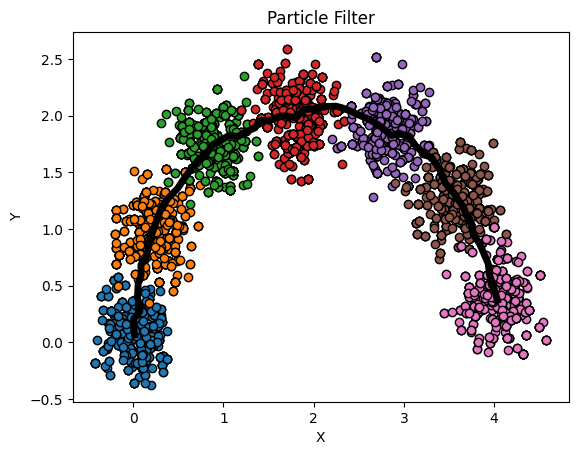

In [16]:
for i in range(7):
    plt.scatter(particleFilter[i*10][0], particleFilter[i*10][1], edgecolors='black')
plt.plot(av_state[0,:], av_state[1,:], linewidth = '5', color = 'black')
plt.title("Particle Filter")
plt.xlabel("X")
plt.ylabel("Y")